In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

def read_ratings(file_path, sep='::'):
    ratings_file = os.path.abspath(file_path)
    column_names = ['userId', 'movieId', 'rating', 'timestamp']
    ratings = pd.read_csv(ratings_file, names=column_names, sep=sep, engine='python')
    ratings = ratings.drop('timestamp', axis=1)
    ratings[['userId', 'movieId']] = ratings[['userId', 'movieId']].astype('int32')
    ratings[['rating']] = ratings[['rating']].astype('int8')
    ratings = ratings.pivot('userId', 'movieId', 'rating').fillna(value=0)
    return ratings

def split_train_test(ratings, test_ratio=0.2):
    test = pd.DataFrame(np.zeros(ratings.shape), index=ratings.index, columns=ratings.columns)
    train = pd.DataFrame(np.zeros(ratings.shape), index=ratings.index, columns=ratings.columns)

    for user in xrange(ratings.shape[0]):
        user_ratings_indexes = ratings.iloc[user, :].nonzero()[0]
        train_indexes, test_indexes = train_test_split(user_ratings_indexes, test_size=test_ratio)
        train.iloc[user, train_indexes] = ratings.iloc[user, train_indexes]
        test.iloc[user, test_indexes] = ratings.iloc[user, test_indexes]

    return train, test

def get_similiarity_matrix(ratings):
    user_similarity = ratings.dot(ratings.transpose())
    normalisation_terms = pd.DataFrame(np.diagonal(user_similarity.values), index=ratings.index).apply(np.sqrt)
    normalisation_terms = normalisation_terms.dot(normalisation_terms.transpose())
    user_similarity = user_similarity.div(normalisation_terms)
    return user_similarity

def get_rmse(predicted, actual):
    return np.sqrt(mean_squared_error(actual.values[actual.values.nonzero()].flatten(),
                                      predicted.values[actual.values.nonzero()].flatten()))

def adjust_user_similarity_knn(user_similarity, k):
        adjusted_similarity = pd.DataFrame(np.zeros(user_similarity.shape),
                                           index=user_similarity.index, columns=user_similarity.columns)

        for user in user_similarity.iterrows():
            top_k_indexes = user[1].sort_values(ascending=False).iloc[0:k+1].index.values
            adjusted_similarity.loc[user[0], top_k_indexes] = user_similarity.loc[user[0], top_k_indexes]

        return adjusted_similarity
        
def predict(ratings, user_similarity, user_means, user_std_devs):
    predictions = user_similarity.dot(ratings)
    denom = user_similarity.abs().sum().transpose()
    predictions = predictions.div(denom, axis='index')
    
    adjusted_predictions_values = predicted.values * self.user_std_devs.values
    adjusted_predicted_values = adjusted_predictions_values + self.user_means.values
    predictions = pd.DataFrame(adjusted_predicted_values).fillna(value=0)
    return predictions

In [2]:
path = os.path.join(os.getcwd(),"..","datasets", "ml1m", "ratings.dat")
full = read_ratings(path)

users= full.index
movies = pd.Index(full.columns.unique())

ratings, test = split_train_test(full)

path = os.path.join(os.getcwd(), "..","datasets", "ml1m", "movies.dat")
movie_names = pd.read_table(path, sep="::", index_col=0, names=['Title', 'Genre'], header = None, engine='python')

In [3]:
len(movie_names['Genre'].unique())

301

In [4]:
genres = set()
for row in movie_names.iterrows():
    for genre in row[1][1].split('|'):
        genres.add(genre)

In [5]:
ratings = ratings.replace(0, np.nan)
user_means = pd.DataFrame(ratings.mean(axis=1), index=ratings.index, columns=['mean']).fillna(value=0)
item_means = pd.DataFrame(ratings.mean(axis=0), index=ratings.columns, columns=['mean']).fillna(value=0)
user_offsets = ratings.subtract(user_means['mean'], 0).abs().mean(axis=1)
new = ratings.subtract(user_means['mean'], 0).divide(user_offsets, 0).transpose().unstack().dropna()

In [6]:
rated = full.replace(0, np.nan).transpose().unstack().dropna()
path = os.path.join(os.getcwd(),"..","datasets", "ml1m.dat")
fo = open(path, "w")

line = str(len(movies)) + " "
for movie in movies:
    line += str(movies.get_loc(movie)) + ":1 "
line += "\n"
fo.write(line)

for user in users:
    doc = ""
    count = 0
    for item in rated.loc[user].iteritems():
        doc = doc + str(movies.get_loc(item[0])) + ":" + str(item[1]) + " "
        count = count + 1
    doc = str(count) + " " + doc + "\n"
    fo.write(doc)
fo.close()

In [7]:
path = os.path.join(os.getcwd(), "..", "param", "ml1m", "beta.dat")
beta = pd.read_table(path, sep=" ", header = None)

for topic in xrange(50):
    top_words = beta.loc[topic].sort_values(ascending=False).index
    genre_count = pd.DataFrame(np.zeros(len(genres)), index = genres)
    
    if topic < 10:
        print topic, " :" ,
    else:
        print topic , ":" , 
        
    for i in xrange(30):
        print movie_names.loc[movies[top_words[i]]][0][:-7], ' |', 
    
    print
    print

0  : Casablanca  | Singin' in the Rain  | West Side Story  | Gone with the Wind  | My Fair Lady  | Shakespeare in Love  | Graduate, The  | African Queen, The  | Wizard of Oz, The  | Breakfast at Tiffany's  | Philadelphia Story, The  | When Harry Met Sally...  | Roman Holiday  | Sense and Sensibility  | Annie Hall  | Witness  | Room with a View, A  | Dangerous Liaisons  | Groundhog Day  | Some Like It Hot  | Princess Bride, The  | Doctor Zhivago  | To Kill a Mockingbird  | Sound of Music, The  | Romeo and Juliet  | Sabrina  | Crying Game, The  | Mary Poppins  | It's a Wonderful Life  | North by Northwest  |

1  : What About Bob?  | F/X  | Kelly's Heroes  | Everything You Always Wanted to Know About Sex  | Steel Magnolias  | Air America  | American Gigolo  | Breaker Morant  | Carlito's Way  | Anatomy of a Murder  | Bronco Billy  | Footloose  | 2 Days in the Valley  | Serpico  | ...And Justice for All  | Bad Lieutenant  | Mulholland Falls  | Easy Money  | Thunderbolt and Lightfoot  | Donn

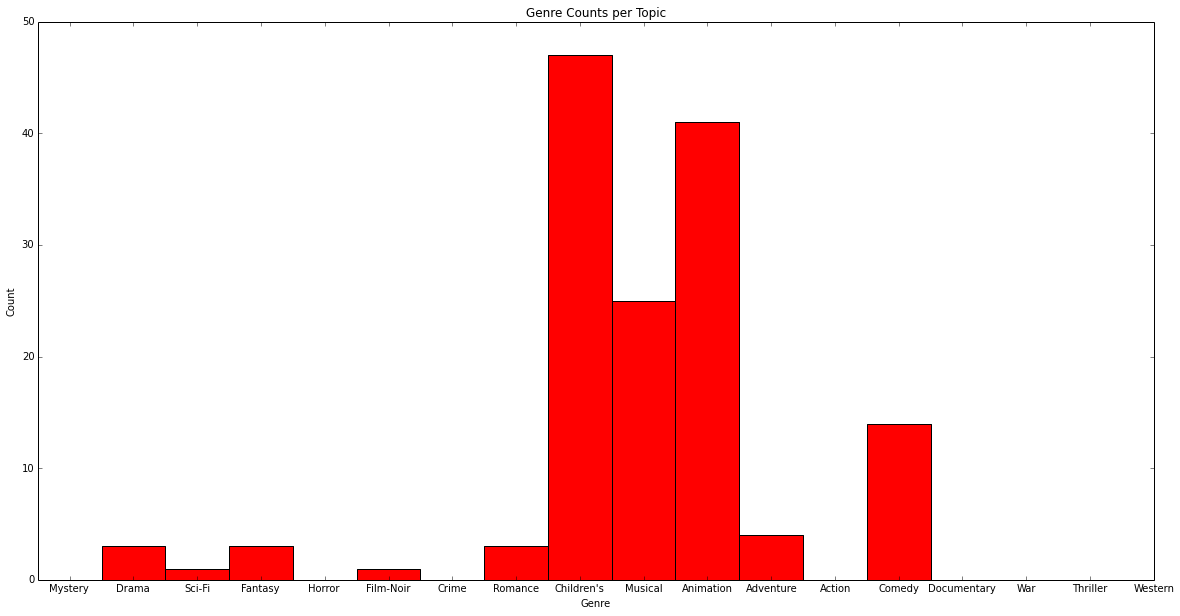

Beauty and the Beast  | Lion King, The  | Aladdin  | Snow White and the Seven Dwarfs  | Cinderella  | Dumbo  | Little Mermaid, The  | 101 Dalmatians  | Sleeping Beauty  | Jungle Book, The  | Bambi  | Alice in Wonderland  | Mulan  | Pinocchio  | Lady and the Tramp  | Fantasia  | Peter Pan  | Toy Story  | Mary Poppins  | Charlotte's Web  | Bug's Life, A  | Tarzan  | Antz  | Toy Story 2  | Hunchback of Notre Dame, The  | Wizard of Oz, The  | Hercules  | Robin Hood  | Sword in the Stone, The  | James and the Giant Peach  | Anastasia  | Prince of Egypt, The  | Pocahontas  | Fox and the Hound, The  | Iron Giant, The  | Aristocats, The  | Rescuers, The  | Muppet Christmas Carol, The  | American Tail, An  | Winnie the Pooh and the Blustery Day  | Rescuers Down Under, The  | Babe  | Secret of NIMH, The  | Nightmare Before Christmas, The  | E.T. the Extra-Terrestrial  | Muppet Movie, The  | Fantasia 2000  | Who Framed Roger Rabbit?  | Willy Wonka and the Chocolate Factory  | Sound of Music, The 

In [10]:
fig, ax = plt.subplots(figsize=(20,10))

ind = np.arange(len(genres)) 
width = 1.0

topic = 29

num_items = 50

top_words = beta.loc[topic].sort_values(ascending=False).index
genre_count = pd.DataFrame(np.zeros(len(genres)), index = genres)

for i in xrange(num_items):
    for gn in movie_names.loc[movies[top_words[i]]][1].split('|'):
        genre_count.loc[gn] = genre_count.loc[gn] + 1

ax.bar(ind, genre_count.values, width=width, color='r')
ind = ind + width

ax.set_ylabel('Count')
ax.set_xlabel('Genre')
ax.set_title('Genre Counts per Topic')
ax.set_xticks(ind-0.5)
xlabels = []
for item in genres:
    xlabels.append(item)
ax.set_xticklabels(xlabels)
plt.show()

for i in xrange(num_items):
        print movie_names.loc[movies[top_words[i]]][0][:-7], ' |', 